In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

In [2]:
install.packages('data.table')

package 'data.table' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'data.table'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\user\anaconda3\Lib\R\library\00LOCK\data.table\libs\x64\datatable.dll to C:\Users\user\anaconda3\Lib\R\library\data.table\libs\x64\datatable.dll: Permission denied"Warning message:
"restored 'data.table'"


The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpQTghuV\downloaded_packages


In [3]:
library(data.table)

Warning message:
"package 'data.table' was built under R version 3.6.3"

In [4]:
install.packages("ggplot2")

package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpQTghuV\downloaded_packages


In [5]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

In [6]:
filePath <- ""
data <- fread(paste0(filePath, "C:/Users/user/Documents/Jupyter/QVI_data2.csv"))

In [7]:
theme_set(theme_bw()) 
theme_update(plot.title = element_text(hjust = 0.5))

In [8]:
data[, YEARMONTH := year(DATE)*100 + month(DATE)]

In [9]:
#### Define the measure calculations 
measureOverTime <‐ data[, .(totSales = sum(TOT_SALES), 
                            nCustomers = uniqueN(LYLTY_CARD_NBR), 
                            nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR),
                            nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID), 
                            avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY)),
                            by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR,YEARMONTH)]

In [10]:
#filter to pre-trial period and stores with full observation periods
storesWithFullObs <‐ unique(measureOverTime[, .N, STORE_NBR][N == 12, STORE_NBR])

preTrialMeasures <‐ measureOverTime[YEARMONTH < 201902 & STORE_NBR %in% storesWithFullObs, ]

In [11]:
#calculate correlation

calculateCorrelation <‐ function(inputTable, metricCol, storeComparison) { 
calcCorrTable = data.table(Store1 = numeric(), Store2 = numeric(), corr_measure = numeric())
    
    storeNumbers <‐ unique(inputTable[, STORE_NBR]) 
    
    for (i in storeNumbers) { 
    calculatedMeasure = data.table("Store1" = storeComparison, "Store2" = i, 
        "corr_measure" = cor(inputTable[STORE_NBR == storeComparison, 
        eval(metricCol)], inputTable[STORE_NBR == i, eval(metricCol)]))

    calcCorrTable <‐ rbind(calcCorrTable, calculatedMeasure) 
    } 
    return(calcCorrTable) 
}

In [12]:
#Create a function to calculate a standardised magnitude distance for a measure

calculateMagnitudeDistance <‐ function(inputTable, metricCol, storeComparison) 
    {
calcDistTable = data.table(Store1 = numeric(), Store2 = numeric(), YEARMONTH = numeric(), measure = numeric())
    
    storeNumbers <‐ unique(inputTable[, STORE_NBR]) 
    
    for (i in storeNumbers) { 
    calculatedMeasure = data.table("Store1" = storeComparison 
                                   , "Store2" = i
                                   ,"YEARMONTH" = inputTable[STORE_NBR == storeComparison, YEARMONTH]
                                   , "measure" = abs(inputTable[STORE_NBR == storeComparison, eval(metricCol)]
                                                     ‐ inputTable[STORE_NBR == i, 
                                                          eval(metricCol)])) 
        
    calcDistTable <‐ rbind(calcDistTable, calculatedMeasure) 
    }
    
#Standardise the magnitude distance so that the measure ranges from 0 to 1 
minMaxDist <‐ calcDistTable[, .(minDist = min(measure), maxDist = max(measure)), by = c("Store1", "YEARMONTH")]

distTable <‐ merge(calcDistTable, minMaxDist, by = c("Store1", "YEARMONTH"))
distTable[, magnitudeMeasure := 1 ‐ (measure ‐ minDist)/(maxDist ‐ minDist)] 
    
finalDistTable <‐ distTable[, .(mag_measure = mean(magnitudeMeasure)), by = .(Store1, Store2)]
    return(finalDistTable) 
}

Store 77

In [13]:
#Use the functions for calculating correlation 
trial_store <‐ 77 
corr_nSales <‐ calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <‐ calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

#Use the functions for calculating magnitude
magnitude_nSales <‐ calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <‐ calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

In [14]:
#Create a combined score composed of correlation and magnitude
corr_weight <‐ 0.5 
score_nSales <‐ merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]

score_nCustomers <‐ merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1 ‐ corr_weight)]

In [15]:
#Combine scores across the drivers 
score_Control <‐ merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))

score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

In [16]:
#Select control stores based on the highest matching store , i.e. the second ranked highest store) 
#Select control store for trial store 77 
control_store <‐ score_Control[Store1 == trial_store, ][order(‐finalControlScore)][2, Store2]

control_store

[1] 233

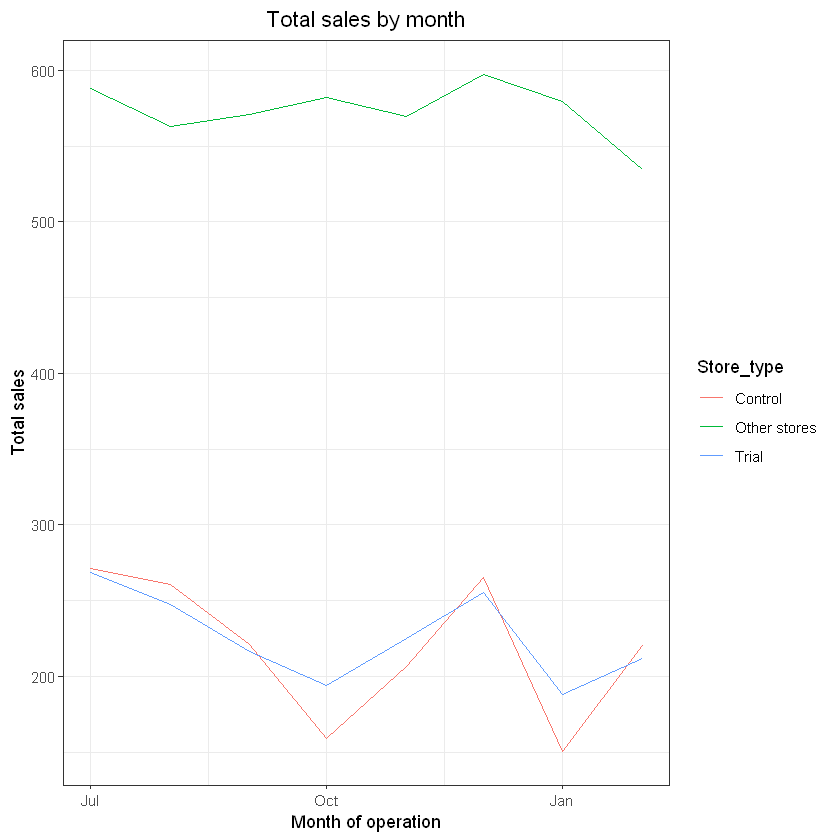

In [17]:
#Visual checks on trends based on the drivers 
measureOverTimeSales <‐ measureOverTime 
pastSales <‐ measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",
                                                         ifelse(STORE_NBR == control_store, "Control", "Other stores"))][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")
                                                         ][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][YEARMONTH < 201903 , ] 

ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) + geom_line() + labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

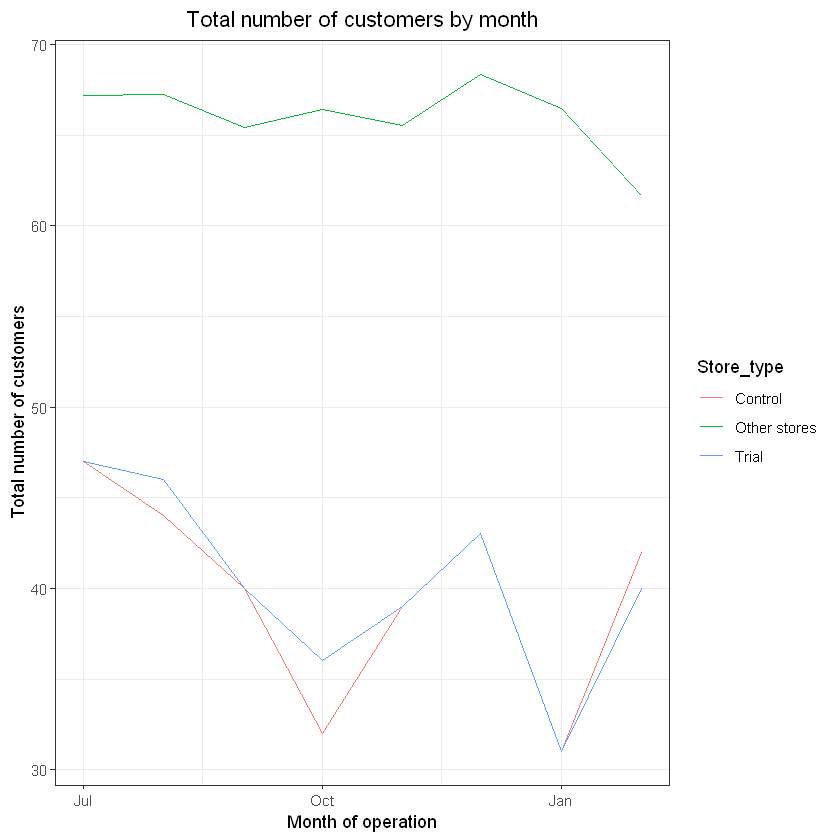

In [18]:
measureOverTimeCusts <‐ measureOverTime 

pastCustomers <‐ measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR == control_store, "Control", "Other stores"))][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d") ][YEARMONTH < 201903 , ]

ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) + geom_line() + labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [19]:
#Scale pre‐trial control sales to match pre‐trial trial store sales
scalingFactorForControlSales <‐ preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(totSales)]

#Apply the scaling factor 

measureOverTimeSales <‐ measureOverTime 
scaledControlSales <‐ measureOverTimeSales[STORE_NBR == control_store, ][ , controlSales := totSales * scalingFactorForControlSales]

In [20]:
#Calculate the percentage difference between scaled control sales and trial sales

percentageDiff <‐ merge(scaledControlSales[, c("YEARMONTH", "controlSales")], measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],
                        by = "YEARMONTH" )[, percentageDiff := abs(controlSales‐totSales)/controlSales]

In [21]:
#Standard Deviation
stdDev <‐ sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
#DOF
degreesOfFreedom <‐ 7

#### We will test with a null hypothesis of there being 0 difference between trial and control stores 
percentageDiff[, tValue := (percentageDiff ‐ 0)/stdDev ][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][YEARMONTH < 201905 & YEARMONTH > 201901, .(TransactionMonth, tValue)]

TransactionMonth,tValue
2019-02-01,1.223912
2019-03-01,5.633494
2019-04-01,11.336505


In [22]:
#95th perecentile
qt(0.95, df = degreesOfFreedom)

[1] 1.894579

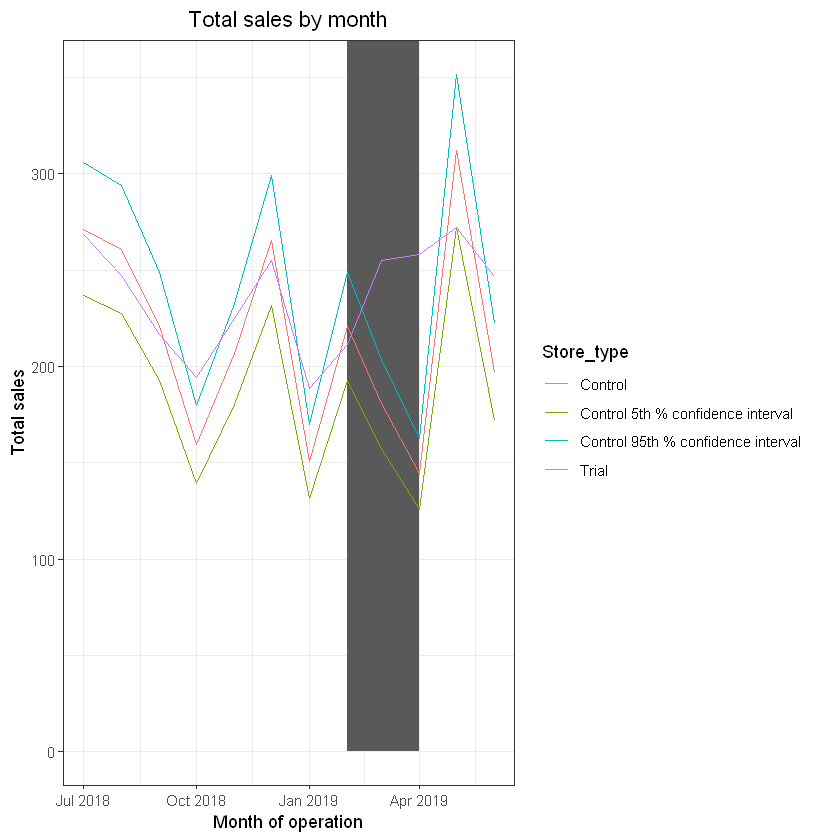

In [23]:
measureOverTimeSales <‐ measureOverTime 
#Trial and control store total sales

pastSales <‐ measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR == control_store, "Control", "Other stores"))][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][Store_type %in% c("Trial", "Control"), ]


# Control store 95th percentile 
pastSales_Controls95 <‐ pastSales[Store_type == "Control", ][, totSales := totSales * (1 + stdDev * 2) ][, Store_type := "Control 95th % confidence interval"]

#Control store 5th percentile 
pastSales_Controls5 <‐ pastSales[Store_type == "Control", ][, totSales := totSales * (1 ‐ stdDev * 2) ][, Store_type := "Control 5th % confidence interval"]

trialAssessment <‐ rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

#Plotting these in one nice graph 

ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) + geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,], aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() + labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")


In [24]:
#Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust <‐ preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(nCustomers)]

#Apply the scaling factor 
measureOverTimeCusts <‐ measureOverTime
scaledControlCustomers <‐ measureOverTimeCusts[STORE_NBR == control_store, ][ , controlCustomers := nCustomers * scalingFactorForControlCust ][, Store_type := ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR == control_store, "Control", "Other stores"))]

#Calculate the percentage difference between scaled control sales and trial sales
percentageDiff <‐ merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")], measureOverTimeCusts[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")], by = "YEARMONTH" )[, percentageDiff := abs(controlCustomers‐nCustomers)/controlCustomers]

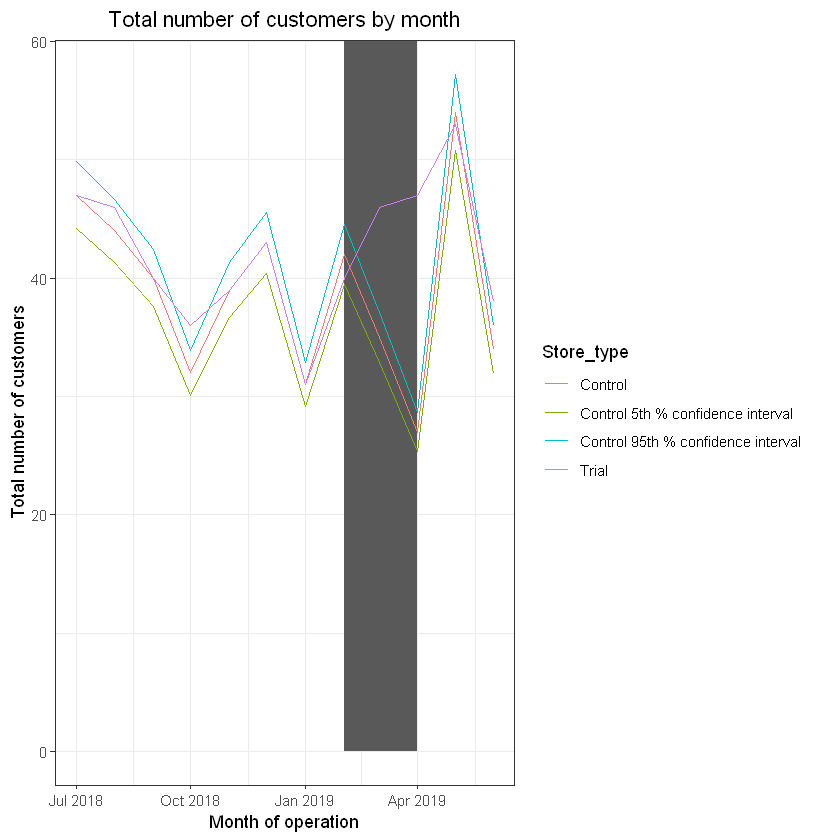

In [25]:
stdDev <‐ sd(percentageDiff[YEARMONTH < 201902 , percentageDiff]) 

degreesOfFreedom <‐ 7

#Trial and control store number of customers 
pastCustomers <‐ measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")][Store_type %in% c("Trial", "Control"), ] 

#Control store 95th percentile 
pastCustomers_Controls95 <‐ pastCustomers[Store_type == "Control", ][, nCusts := nCusts * (1 + stdDev * 2) ][, Store_type := "Control 95th % confidence interval"]

#Control store 5th percentile 
pastCustomers_Controls5 <‐ pastCustomers[Store_type == "Control", ][, nCusts := nCusts * (1 ‐ stdDev * 2) ][, Store_type := "Control 5th % confidence interval"]

trialAssessment <‐ rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

#Plotting these in one nice graph 

ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) + geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,], aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() + labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

Store 88

In [26]:
measureOverTime <‐ data[, .(totSales = sum(TOT_SALES), nCustomers = uniqueN(LYLTY_CARD_NBR), nTxnPerCust = uniqueN(TXN_ID)/uniqueN(LYLTY_CARD_NBR), nChipsPerTxn = sum(PROD_QTY)/uniqueN(TXN_ID), avgPricePerUnit = sum(TOT_SALES)/sum(PROD_QTY) ) , by = c("STORE_NBR", "YEARMONTH")][order(STORE_NBR, YEARMONTH)]

#Use the functions for calculating correlation 
trial_store <‐ 88 
corr_nSales <‐ calculateCorrelation(preTrialMeasures, quote(totSales), trial_store)
corr_nCustomers <‐ calculateCorrelation(preTrialMeasures, quote(nCustomers), trial_store)

#Use the functions for calculating magnitude 
magnitude_nSales <‐ calculateMagnitudeDistance(preTrialMeasures, quote(totSales), trial_store)
magnitude_nCustomers <‐ calculateMagnitudeDistance(preTrialMeasures, quote(nCustomers), trial_store)

#Create a combined score composed of correlation and magnitude 
corr_weight <‐ 0.5 
score_nSales <‐ merge(corr_nSales, magnitude_nSales, by = c("Store1", "Store2"))[, scoreNSales := corr_measure * corr_weight + mag_measure * (1 - corr_weight)]
score_nCustomers <‐ merge(corr_nCustomers, magnitude_nCustomers, by = c("Store1", "Store2"))[, scoreNCust := corr_measure * corr_weight + mag_measure * (1 ‐ corr_weight)]

#Combine scores across the drivers 
score_Control <‐ merge(score_nSales, score_nCustomers, by = c("Store1", "Store2"))
score_Control[, finalControlScore := scoreNSales * 0.5 + scoreNCust * 0.5]

#Select control store for trial store 88 
control_store <‐ score_Control[Store1 == trial_store, ][order(‐finalControlScore)][2, Store2]
control_store

[1] 237

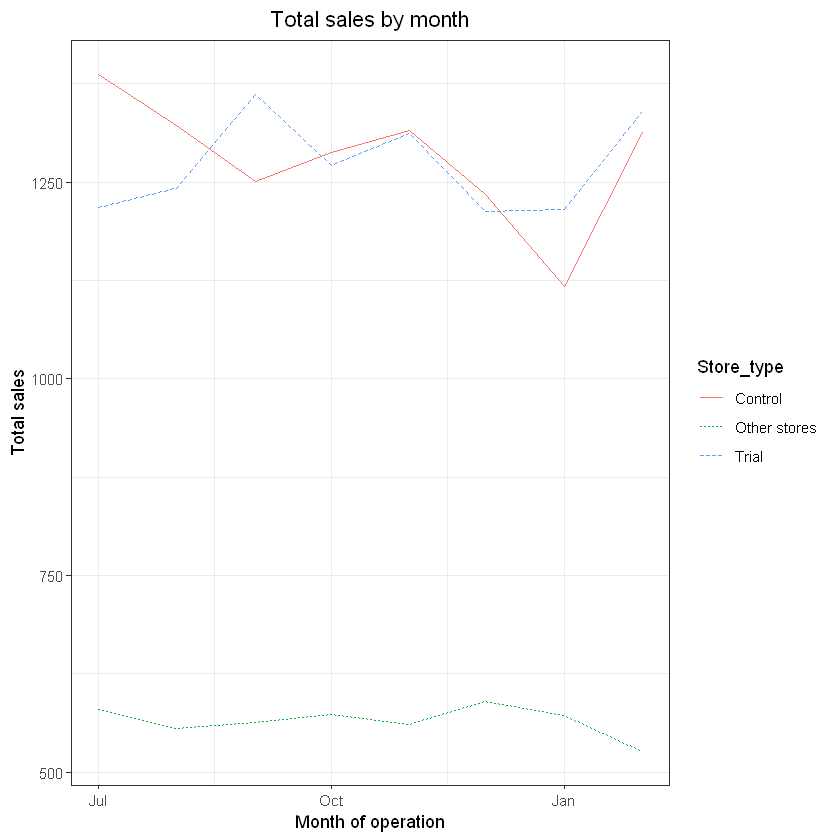

In [27]:
#Visual checks on trends based on the drivers
measureOverTimeSales <‐ measureOverTime 
pastSales <‐ measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR == control_store, "Control", "Other stores"))][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][YEARMONTH < 201903 , ] 

ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) + geom_line(aes(linetype = Store_type)) + labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

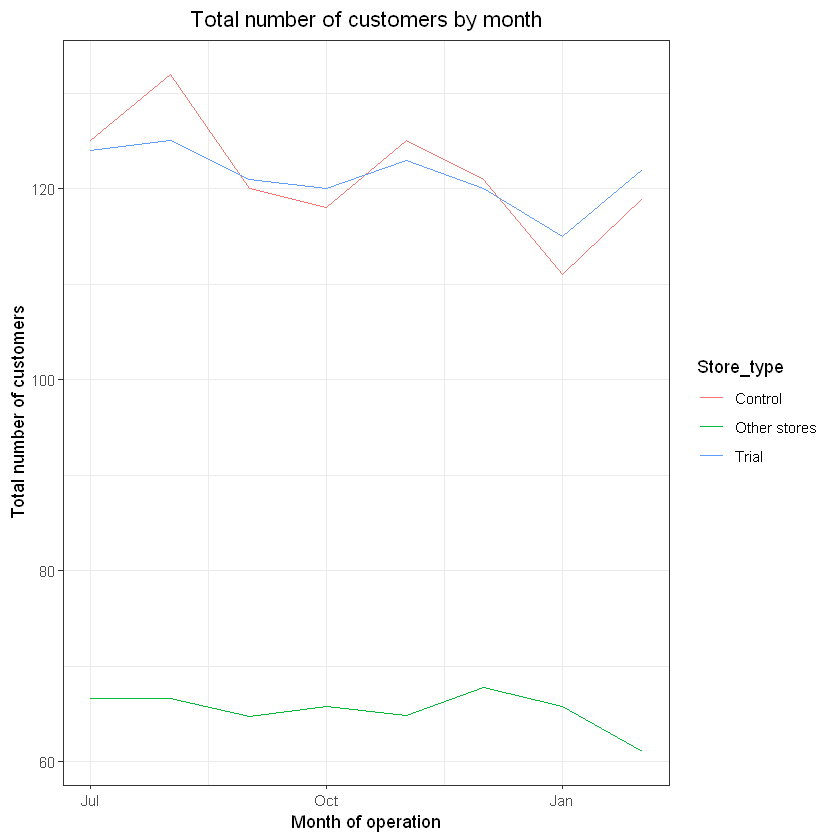

In [28]:
#Visual checks on trends based on the drivers 
measureOverTimeCusts <‐ measureOverTime 
pastCustomers <‐ measureOverTimeCusts[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",ifelse(STORE_NBR == control_store, "Control", "Other stores"))][, numberCustomers := mean(nCustomers), by = c("YEARMONTH", "Store_type")][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][YEARMONTH < 201903 , ]

ggplot(pastCustomers, aes(TransactionMonth, numberCustomers, color = Store_type)) + geom_line() + labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

Impact of trial on sales

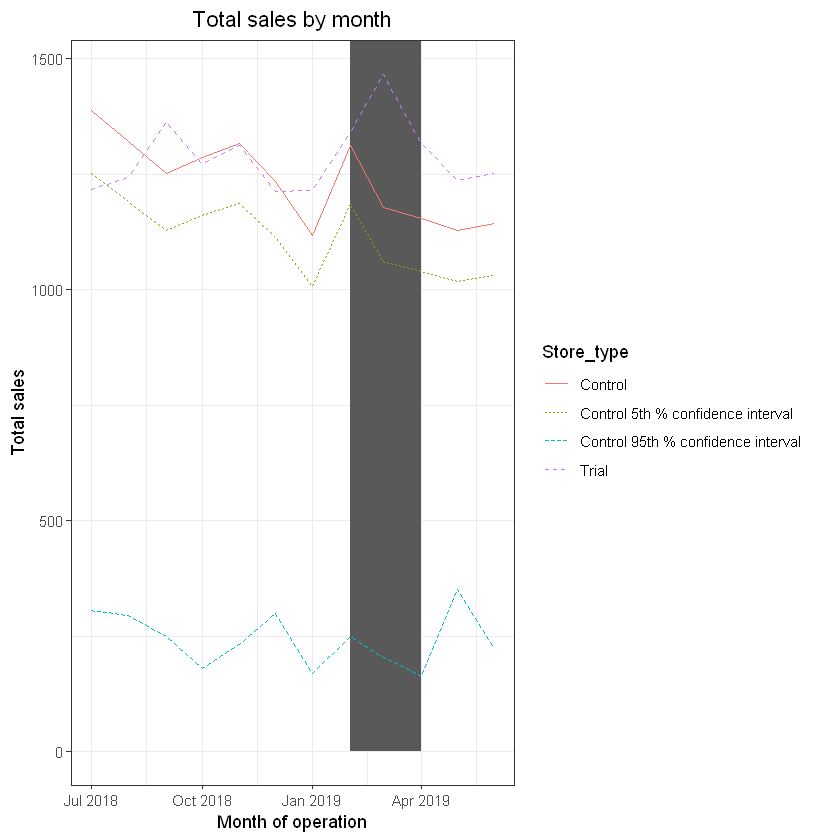

In [29]:
#Scale pre‐trial control sales to match pre‐trial trial store sales 
scalingFactorForControlSales <‐ preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(totSales)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(totSales)]

#Apply the scaling factor 
measureOverTimeSales <‐ measureOverTime 
scaledControlSales <‐ measureOverTimeSales[STORE_NBR == control_store, ][ , controlSales := totSales * scalingFactorForControlSales]

#Calculate the percentage difference between scaled control sales and trial sales
percentageDiff <‐ merge(scaledControlSales[, c("YEARMONTH", "controlSales")], measureOverTime[STORE_NBR == trial_store, c("totSales", "YEARMONTH")],by = "YEARMONTH" )[, percentageDiff := abs(controlSales‐totSales)/controlSales]

stdDev <‐ sd(percentageDiff[YEARMONTH < 201902 , percentageDiff])
degreesOfFreedom <‐ 7

#Trial and control store total sales 
measureOverTimeSales <‐ measureOverTime

pastSales <‐ measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR == control_store, "Control", "Other stores"))][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")][, TransactionMonth := as.Date(paste(YEARMONTH %/% 100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][Store_type %in% c("Trial", "Control"), ]

#Control store 5th percentile 
pastSales_Controls5 <‐ pastSales[Store_type == "Control", ][, totSales := totSales * (1 ‐ stdDev * 2) ][, Store_type := "Control 5th % confidence interval"]

trialAssessment <‐ rbind(pastSales, pastSales_Controls95, pastSales_Controls5)

#Plotting these in one nice graph 
ggplot(trialAssessment, aes(TransactionMonth, totSales, color = Store_type)) + geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,], aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) + geom_line(aes(linetype = Store_type)) + labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")

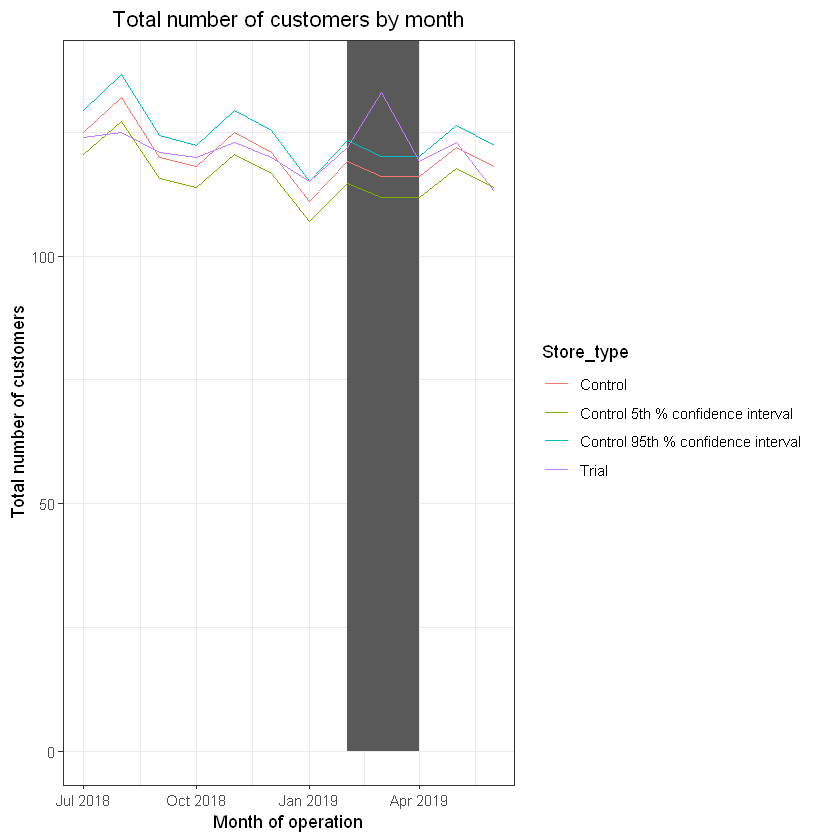

In [30]:
#Scale pre‐trial control customers to match pre‐trial trial store customers
scalingFactorForControlCust <‐ preTrialMeasures[STORE_NBR == trial_store & YEARMONTH < 201902, sum(nCustomers)]/preTrialMeasures[STORE_NBR == control_store & YEARMONTH < 201902, sum(nCustomers)]

#Apply the scaling factor 
measureOverTimeCusts <‐ measureOverTime 
scaledControlCustomers <‐ measureOverTimeCusts[STORE_NBR == control_store, ][ , controlCustomers := nCustomers * scalingFactorForControlCust][, Store_type := ifelse(STORE_NBR == trial_store, "Trial", ifelse(STORE_NBR == control_store, "Control", "Other stores"))] 

#Calculate the percentage difference between scaled control sales and trial sales
percentageDiff <‐ merge(scaledControlCustomers[, c("YEARMONTH", "controlCustomers")],measureOverTime[STORE_NBR == trial_store, c("nCustomers", "YEARMONTH")], by = "YEARMONTH" )[, percentageDiff := abs(controlCustomers‐nCustomers)/controlCustomers]

stdDev <‐ sd(percentageDiff[YEARMONTH < 201902 , percentageDiff]) 
degreesOfFreedom <‐ 7

#Trial and control store number of customers
pastCustomers <‐ measureOverTimeCusts[, nCusts := mean(nCustomers), by = c("YEARMONTH", "Store_type")][Store_type %in% c("Trial", "Control"), ]

#Control store 95th percentile 
pastCustomers_Controls95 <‐ pastCustomers[Store_type == "Control", ][, nCusts := nCusts * (1 + stdDev * 2) ][, Store_type := "Control 95th % confidence interval"]

#Control store 5th percentile 
pastCustomers_Controls5 <‐ pastCustomers[Store_type == "Control", ][, nCusts := nCusts * (1 ‐ stdDev * 2) ][, Store_type := "Control 5th % confidence interval"]

trialAssessment <‐ rbind(pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5)

#Plotting these in a graph 
ggplot(trialAssessment, aes(TransactionMonth, nCusts, color = Store_type)) + geom_rect(data = trialAssessment[ YEARMONTH < 201905 & YEARMONTH > 201901 ,], aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0 , ymax = Inf, color = NULL), show.legend = FALSE) + geom_line() + labs(x = "Month of operation", y = "Total number of customers", title = "Total number of customers by month")

In [31]:
fwrite(data, paste0(filePath,"QVI_data_part2.csv"))